In [61]:
import ssm
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Conspecific_Tracking_ta_edit_117 as cs
from scipy import interpolate 
from scipy import misc
from beating import rotation,tail_spline

In [99]:
path = "/Users/miaoyuqi/研究/Statistical analyses of Siamese fighting fish aggressive behavior/DSI-Students/Yuqi_scripts/top example.h5"
f = pd.HDFStore(path,'r')
data_top = f.get('df_with_missing')

In [100]:
data_top.columns = data_top.columns.droplevel()
data_top1 = cs.auto_scoring_tracefilter(data_top)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
data_top2 = data_top1[data_top1.isnull()["F_spine1"]["x"]== False].fillna(method = "ffill")

In [89]:
def rotation(data):
    n = data.shape[0]
    ## transfer spline data to point vector
    spline_point = []
    x_index = [0, 15, 18, 21, 24, 27, 30, 33]
    y_index = [1, 16, 19, 22, 25, 28, 31, 34]
    x = data.iloc[:,x_index]
    y = data.iloc[:,y_index]
    spline_point = np.column_stack([x,y])
    
    ## reference vector
    head = np.column_stack([data.iloc[:,0],data.iloc[:,1]]) # dim = 216059, 2
    spline1 = np.column_stack([data.iloc[:,15],data.iloc[:,16]])
    # dim = 216059, 2
    head_r = head-spline1 # reference vector to x axis
    
    ##  rotation matrix 
    norm = []
    for i in range(len(head_r)):
        norm.append(np.linalg.norm(head_r[i]))
    norm = np.array(norm)
    angle = np.column_stack([head_r[:,0]/norm, head_r[:,1]/norm])
    angle2 = np.column_stack([-angle[:,1],angle[:,0]])
    rot_matrix = np.column_stack([angle,angle2])
    
    ## rotate point coordinates
    spline_rotate = []
    for i in range(n):
        x = []
        for j in spline_point[i].reshape((8,2), order = "F"):
            x.append((np.dot(rot_matrix[i].reshape(2,2),j-spline1[i])))
        spline_rotate.append(x)
    
    return(spline_rotate)
    
    
def tail_spline(rotate_points):
    tail = []
    for i in range(len(rotate_points)):
        pts = np.array(rotate_points[i])
        tck, u = interpolate.splprep(pts.T, u=None, s=0.0)
        x = np.vstack(rotate_points[i])[:,0]
        yder = interpolate.splev(u, tck, der=1)
        tail.append((yder[1])/(yder[0]))
    return(tail)

In [82]:
rotate_spline = rotation(data_top2.iloc[90000:95000,:])

In [90]:
y_der = tail_spline(rotate_spline)

In [93]:
i = 1000
y_der[i]

array([-0.4187815 ,  0.30029501,  0.24497423, -0.02046735, -0.21943318,
       -0.49153208, -1.05888663, -1.23305396])

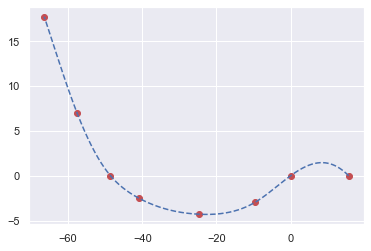

In [94]:
pts = np.array(rotate_spline[i])
tck, u = interpolate.splprep(pts.T, u=None, s=0.0) 
u_new = np.linspace(u.min(), u.max(), 1000)
x_new, y_new = interpolate.splev(u_new, tck, der=0)

plt.plot(pts[:,0], pts[:,1], 'ro')
plt.plot(x_new, y_new, 'b--')
plt.show()